In [1]:
import numpy as np
import schnell
import matplotlib.pyplot as plt
# from matplotlib import rc

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 14,
})

In [3]:
t_obs = 4                           # observation time length, years
obs_time = t_obs * 365 * 24 * 3600  # obs time in unit second
f_ref = 3e-3                        # reference frequency, Hz
Nf = 256                            # number of frequency bins
freqs = np.geomspace(1e-5, 1, Nf)   # equal-log linspace sampling
nside = 8                           # used for healpix

def GW_sw(f, fp, A):
    # fitting formula for Omega_GW as a function of f/fp and A
    S = (f/fp)**3*((7/(4+3*(f/fp)**2))**(7/2))
    return A * S

def n_gw(f, fp):
    # d(lnOmega_GW)/d(lnf) as a function of f/fp
    s = 28/(4+3*(f/fp)**2)-4
    return s

fpeak = 3e-3                # GW peak frequency
A = 1e-12                   # GW Amplitude
gw = GW_sw(freqs, fpeak, A) # Power spectrum density for GW
n_t_sw = n_gw(freqs, fpeak) # Spectral index
f_ref = 3e-3                # reference frequency, Hz
ls = np.arange(3 * nside)   # maximum ls


dets = [schnell.LISADetector(i) for i in range(3)]  # define the detectors
rho = schnell.NoiseCorrelationLISA(dets[0])         # evaluate the correlation matrix
mca = schnell.MapCalculator(dets, f_pivot = f_ref, spectral_index=n_t_sw, corr_matrix = rho) # 2/3

pi_LISA = mca.get_pi_curve(obs_time, freqs, nside, is_fspacing_log = True, nsigma = 1, LISA=True)
nl_all = mca.get_N_ell(obs_time, freqs, nside, is_fspacing_log = True, LISA=True)
gl_all = mca.get_G_ell(obs_time, freqs, nside, LISA=True)
# is_f, S_f = mca._get_iS_f(freqs, pmat=None, saveSf=True, LISA=True)

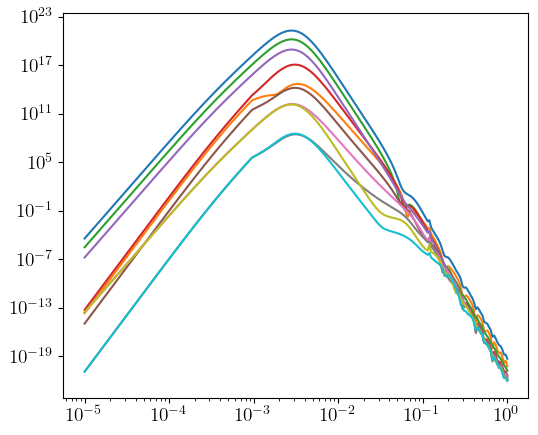

In [4]:
fig = plt.figure(figsize=(6,5))

for i in range(10):
    plt.plot(freqs, gl_all[:,i])
plt.xscale('log')
plt.yscale('log')
# plt.ylim([1e-30,1e25])

plt.show()

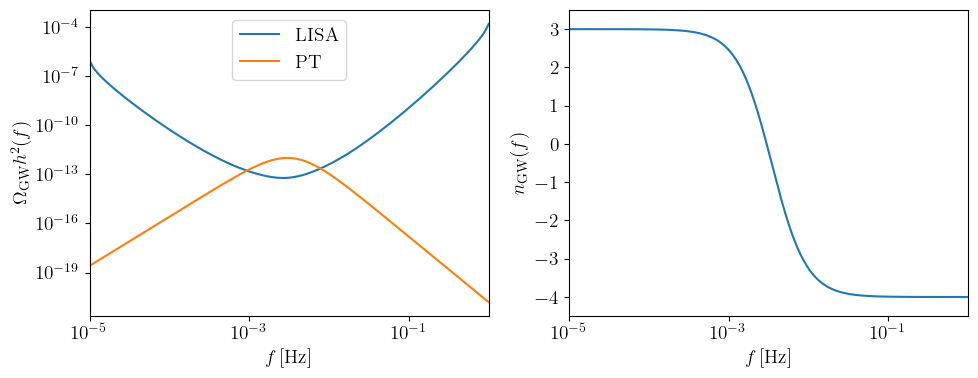

In [32]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.loglog(freqs, 0.67**2*pi_LISA, label='LISA')
plt.loglog(freqs, gw, label='PT')
plt.xlabel(r'$f\,[{\rm Hz}]$')
plt.ylabel(r'$\Omega_{\rm GW}h^2(f)$')
plt.xlim([1e-5,1])
plt.legend(loc='upper center')

plt.subplot(1,2,2)
plt.semilogx(freqs, n_t_sw)
plt.xlabel(r'$f\,[{\rm Hz}]$')
plt.ylabel(r'$n_{\rm GW}(f)$')
plt.xlim([1e-5,1])
plt.ylim([-4.5,3.5])
plt.yticks(np.arange(-4,4))

plt.tight_layout()
plt.savefig("GW_PT.pdf")
plt.show()

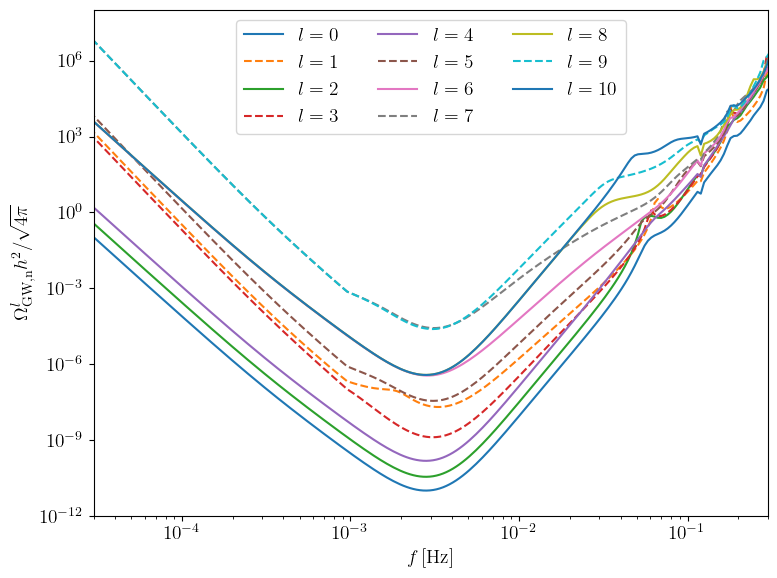

In [31]:
fig = plt.figure(figsize=(8,6))

for i in range(11):
    data = (0.67)**2/(np.sqrt(gl_all[:,i]))
    if i%2 == 0:
        plt.loglog(freqs, data, label = rf'$l={i}$')
    else:
        plt.loglog(freqs, data, '--', label = rf'$l={i}$')

plt.xlabel(r'$f\,[{\rm Hz}]$')
plt.ylabel(r'$\Omega_{\rm GW,n}^{l}h^2/\sqrt{4\pi}$')
plt.legend(ncol=3)
    
plt.xlim([3e-5,3e-1])
plt.ylim([1e-12,1e8])
plt.tight_layout()
plt.savefig("nl_LISA.pdf", bbox_inches='tight')
plt.show()

In [8]:
lmax = 8
llist = np.arange(lmax+1)
D_l = np.load('LISA_band_SNR/PTGWB_Dl.npy')
C_l = D_l[:,:lmax+1]/llist/(llist + 1)

C_l.shape

/var/folders/j8/mz7l4_197pn37cbb5wq5lgw40000gn/T/ipykernel_45671/3735480106.py:4: RuntimeWarning: invalid value encountered in true_divide
  C_l = D_l[:,:lmax+1]/llist/(llist + 1)


(3, 9)

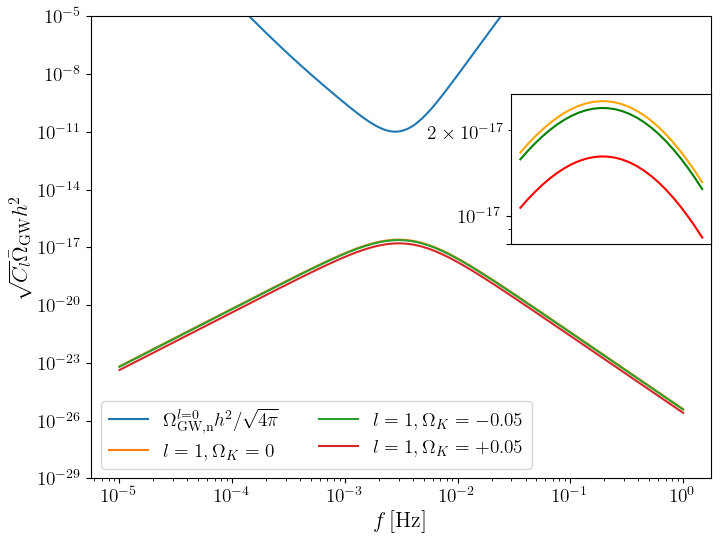

In [29]:
data_flat_l1 = np.sqrt(C_l[0,1])*gw
data_open_l1 = np.sqrt(C_l[1,1])*gw
data_closed_l1 = np.sqrt(C_l[2,1])*gw

fig = plt.figure(figsize=(8,6))

#####################
# 1. main plot
plt.loglog(freqs, (0.67)**2/(np.sqrt(gl_all[:,0])), label = r'$\Omega_{\rm GW,n}^{l=0}h^2/\sqrt{4\pi}$')

plt.loglog(freqs, data_flat_l1, label=r'$l=1,\Omega_K=0$')
plt.loglog(freqs, data_open_l1, label=r'$l=1,\Omega_K=-0.05$')
plt.loglog(freqs, data_closed_l1, label=r'$l=1,\Omega_K=+0.05$')
plt.legend(loc='best', ncol=2)

plt.xlabel(r'$f\,[{\rm Hz}]$', fontsize=16)
plt.ylabel(r'$\sqrt{C_{l}}\bar{\Omega}_{\rm GW}h^2$', fontsize=16)
plt.ylim(1e-29, 1e-5)

#####################
# 2. subplot
ax = fig.add_axes([0.65, 0.5, 0.25, 0.25])
fi, fe = 115, 141
ax.loglog(freqs[fi:fe], data_flat_l1[fi:fe], 'orange')
ax.loglog(freqs[fi:fe], data_open_l1[fi:fe], 'green')
ax.loglog(freqs[fi:fe], data_closed_l1[fi:fe], 'red')
# ax.set_ylim([6e-18, 2e-17])
ax.set_yticks([8e-18, 1e-17])
ax.xaxis.set_visible(False)


plt.savefig('S_PT.pdf')
plt.show()

In [ ]:
snr = np.empty([3, lmax])

for i in range(3):
    SNR_l_df = C_l[i, 1:, None] * gw[None, :]**2 * gl_all[:,1:lmax+1].T
    SNR_l = np.trapz(SNR_l_df, freqs) * obs_time
    snr[i] = np.array(SNR_l)
    # print(SNR_l.shape)

print(snr)

[[5.84079700e-14 5.00133074e-09 1.89941819e-12 7.56722000e-11
  9.88275707e-16 6.86342373e-18 9.35622641e-22 3.26204598e-18]
 [5.23450410e-14 5.21182696e-09 1.99733358e-12 7.88990939e-11
  1.02218991e-15 7.05685899e-18 9.57779934e-22 3.32828600e-18]
 [2.40678452e-14 4.11660439e-09 1.77526366e-12 7.28201719e-11
  9.59301904e-16 6.70106972e-18 9.17227070e-22 3.20750405e-18]]


In [ ]:
# Here we use the Dl at peak frequency for estimation

Cross_PTGWB = np.load('LISA_band_SNR/PTGWB_CMB_cross.npy', allow_pickle=True)[:,2:lmax+1]
Dl_PTGWB = np.load('LISA_band_SNR/PTGWB_Dl.npy')[:,2:lmax+1]
Dl_CMB = np.load('LISA_band_SNR/CMB_Dl.npy')[:,2:lmax+1]

print(Cross_PTGWB.shape, Dl_PTGWB.shape, Dl_CMB.shape)

(3, 7) (3, 7) (3, 7)


In [ ]:
# Here $N_l$ is estimated by nl_all multiplied by two times peak amplitude of Omega_GW

fsky = 1
snr2_cross = np.empty([3, lmax-1])
for i in range(3):
    snr2_cross_l = fsky * (2*llist[2:] + 1) * Cross_PTGWB[i]**2 / (Dl_CMB[i]*(Dl_PTGWB[i] + nl_all[2:lmax+1]*10**24)+Cross_PTGWB[i]**2)
    snr2_cross[i] = np.cumsum(snr2_cross_l)

snr2_cross = np.sqrt(snr2_cross)

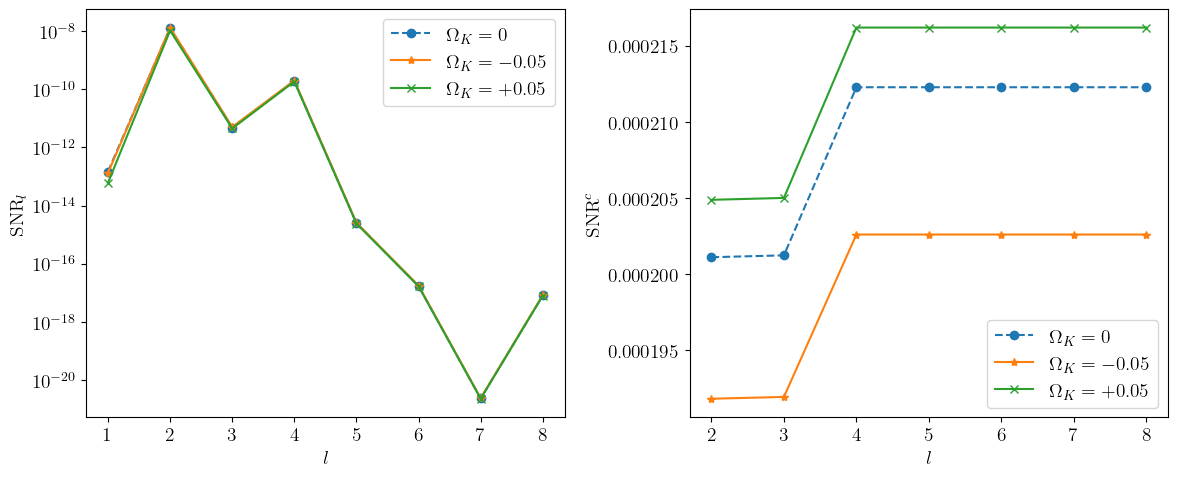

In [28]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.semilogy(llist[1:], np.sqrt(2*np.pi)*snr[0], '--o', label=r'$\Omega_K=0$')
plt.semilogy(llist[1:], np.sqrt(2*np.pi)*snr[1],'-*', label=r'$\Omega_K=-0.05$')
plt.semilogy(llist[1:], np.sqrt(2*np.pi)*snr[2],'-x', label=r'$\Omega_K=+0.05$')
plt.legend(loc='best',ncol=1)
plt.xlabel(r'$l$')
plt.ylabel(r'$\mathrm{SNR}_{l}$')


plt.subplot(1,2,2)
plt.plot(llist[2:], snr2_cross[0], '--o', label=r'$\Omega_K=0$')
plt.plot(llist[2:], snr2_cross[1], '-*', label=r'$\Omega_K=-0.05$')
plt.plot(llist[2:], snr2_cross[2], '-x', label=r'$\Omega_K=+0.05$')
plt.legend(loc='best',ncol=1)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$l$')
plt.ylabel(r'$\mathrm{SNR}^{c}$')


plt.tight_layout()
plt.savefig('SNR.pdf')
plt.show()